## [Natural Language Understanding - Core Component of Conversational Agent](https://towardsdatascience.com/natural-language-understanding-core-component-of-conversational-agent-3e51357ca934)

__Example Utterance__: I would like to book my air ticket from A to C.  
__Intent__: reserve a flight from one location (A) to another location (C) ('reserve ticket').  
__Entity__: Departure City, Destination City  
Using __chatbot corpus__ (https://github.com/sebischair/NLU-Evaluation-Corpora)

Two approaches to create conversational agent: rule-based (regex) and self learning (Machine Learning).

Word vectors: continuous bag of words (CBOW) tries to guess a single word using the neighboring words, while the skip gram uses a single word to predict its neighboring words in a window
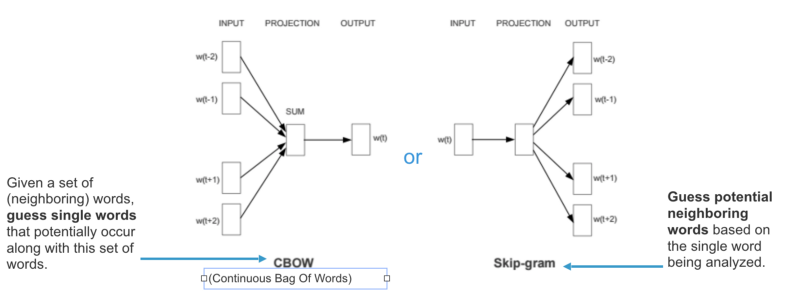

Spacy's 'en_core_web_lg' model uses 300-dimensional GloVe vectors for over 1 million terms of English  
More on word vectors [here](https://spacy.io/usage/vectors-similarity#custom)

In [1]:
import json
import spacy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# LOAD DATA
with open('chatbot.json') as f:
    data = json.load(f)
    
text, intent = [], []
for i in range(len(data['sentences'])):
    text.append(data['sentences'][i]['text'])
    intent.append(data['sentences'][i]['intent'])
    
df = pd.DataFrame({'text': text, 'intent': intent})
df.head()

,text,intent
0,i want to go marienplatz,FindConnection
1,when is the next train in muncher freiheit?,DepartureTime
2,when does the next u-bahn leaves from garching...,DepartureTime
3,from olympia einkaufszentrum to hauptbahnhof,FindConnection
4,when is the next train from winterstraße 12 to...,FindConnection


## BASELINE INTENT CLASSIFIER

In [3]:
queries=np.array(df['text'])
labels=np.array(df['intent'])

In [4]:
#CONVERT TEXT TO PRETRAINED VECTORS
nlp = spacy.load('en_core_web_lg')
n_queries = len(queries)
dim_embedding = nlp.vocab.vectors_length
X = np.zeros((n_queries, dim_embedding))

for idx, query in enumerate(queries):
    doc = nlp(query)
    X[idx, :] = doc.vector
    
X.shape

(206, 300)

In [5]:
# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3)
print('Train X:', X_train.shape)
print('Train y:', y_train.shape)
print('Test X:', X_test.shape)
print('Test y:', y_test.shape)

Train X: (144, 300)
Train y: (144,)
Test X: (62, 300)
Test y: (62,)


In [6]:
# TRAINING, METRICS
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print("Accuracy on Test Set: ", np.count_nonzero(clf.predict(X_test)==y_test)/len(y_test))

Accuracy on Test Set:  1.0


In [7]:
# ONE PREDICTION
i = 11
doc = nlp(queries[i])
print(queries[i])
print('Ground truth:', labels[i])
print('  Prediction:', clf.predict(doc.vector.reshape(1,-1))[0])

when is the next s-bahn leaving at garching?
Ground truth: DepartureTime
  Prediction: DepartureTime


## BASELINE NAMED ENTITY RECOGNITION

In [8]:
doc = nlp('from New York to Washington')
for ent in doc.ents:
    print(ent.text, ent.label_)

New York GPE
Washington GPE


After identifying intent and entities, we can generate a query to fetch a response from the DB:  
 `SELECT ___ FROM CONNECTIONS  
 WHERE START_LOCATION='Departure City'  
 AND END_LOCATION='Arrival City'` 
 
__You can even train Spacy NER with custom entities__. There are various entities extractors available such as CRFEntityExtractor, MitieEntityExtractor, EntitySynonymMapper, etc to train your custom entities. 

There are various chatbot platforms available that support NLU including Dialog Flow, IBM Watson, RASA NLU.

__References__  
[1] https://medium.com/bhavaniravi/entity-extraction-demistifying-rasanlu-part-3-13a460451573  
[2] https://github.com/sebischair  
[3] https://repl.it/@just_a_girl/Datacamp-Using-Spacy-for-NLP  
[4] https://www.datacamp.com/community/tutorials  
[5] https://www.sigdial.org/files/workshops/conference18/proceedings/pdf/SIGDIAL22.pdf  
[6] https://en.wikipedia.org/wiki/Word_embedding  
[7] https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281  
[8] https://chatbotsjournal.com/chatbots-and-employers-7a3d5b21daaa  
[9] https://docs.furhat.io/nlu/